<a href="https://colab.research.google.com/github/parthnaik13/NYRA/blob/main/4_1_POC1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# POC 1

https://www.kaggle.com/competitions/big-data-derby-2022/overview

A univariate view of the load managment line of research to be explored for the Big Data Derby competition


Things to look at

1. Can we see any correlation between avg speeds of horses in races and their finish positions?
  * Is it appropriate to use avg race speeds as a horse performance criteria?

2. Horse performance over the race season
  * We are trying to see if there is a dip in the performance of horses in races as the race season progress (potentially due to the load the horse has to deal with due to the races it runs throughout the season), we use avg race speed as metric to gauge the performance of a horse
  * Select races on "Dirt" tracks and track condition is "FT"
  * Plot avg speeds for example horses across races from the start of the season to the end of the season (look at horses which have atleast 5 races per season)
    * Do we see the plots having a -ve slope?
    * Do we see differences between the slopes of the plots across different horses?



## Setup

* Mount google drive
* Load necessary python libraries
* Load the nyra_race_horse_speed.csv dataframe which contains race details for each horse along with its unique id, name, finish position and avg race speed, prepared in `3.1_Data_Prep.ipynb`

In [1]:
# Mount google drive to access data files
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# Import necessary libs and print out their versions
import numpy as np
np.random.seed(7)

import pandas as pd
pd.set_option('display.max_columns', None) # Display all dataframe columns

import matplotlib
import matplotlib.pyplot as plt

print(f'numpy version - {np.__version__}')
print(f'pandas version - {pd.__version__}')
print(f'matplotlib version - {matplotlib.__version__}')

numpy version - 1.21.6
pandas version - 1.3.5
matplotlib version - 3.2.2


In [3]:
# Load the nyra_race_horse_speed dataframe from drive
nyra_df = pd.read_csv('/content/drive/MyDrive/NYRA_Data/nyra_race_horse_speed.csv', index_col = 0)
print(f'Shape of the df - {nyra_df.shape}')
nyra_df.head(5)

Shape of the df - (15080, 18)


,track_id,race_date,race_number,program_number,distance_id,course_type,track_condition,run_up_distance,race_type,purse,post_time,weight_carried,jockey,odds,horse_id,finishing_place,horse_name,avg_race_speed
0,AQU,2019-01-01,1,3,650,D,MY,36,AOC,80000,1900-01-01 12:20:00,118,Jose Lezcano,180,3,4,Friend of Liberty,40.323190
1,AQU,2019-01-01,1,4,650,D,MY,36,AOC,80000,1900-01-01 12:20:00,123,Jomar Garcia,1280,4,5,Bobby's Song,40.437696
2,AQU,2019-01-01,1,5,650,D,MY,36,AOC,80000,1900-01-01 12:20:00,118,Manuel Franco,1150,0,1,Jc's Shooting Star,41.286390
3,AQU,2019-01-01,1,1,650,D,MY,36,AOC,80000,1900-01-01 12:20:00,123,Dylan Davis,130,1,2,Sounds Delicious,40.898308
4,AQU,2019-01-01,1,2,650,D,MY,36,AOC,80000,1900-01-01 12:20:00,120,Junior Alvarado,295,2,3,Crimson Frost,40.441267


In [4]:
# Assign proper dtypes wherever needed
# race_date as datetime col
nyra_df['race_date'] = pd.to_datetime(nyra_df['race_date'])
# race_number as a int/numeric col
nyra_df['race_number'] = pd.to_numeric(nyra_df['race_number'])
# post_time as a datetime col
nyra_df['post_time'] = pd.to_datetime(nyra_df['post_time'])

## Avg race speeds vs finish positions

In [5]:
# Get the rank for each horse for a race using the avg_race_speed
# The fastest horse will have a speed_rank of 1, the second fastest will have a speed_rank of 2
nyra_df['speed_rank'] = nyra_df.groupby(['track_id', 'race_date', 'race_number'])['avg_race_speed'].rank(method = 'dense', ascending = False)
nyra_df.loc[:, ['track_id', 'race_date', 'race_number', 'horse_id', 'finishing_place', 'speed_rank']].head(5)

,track_id,race_date,race_number,horse_id,finishing_place,speed_rank
0,AQU,2019-01-01,1,3,4,5.0
1,AQU,2019-01-01,1,4,5,4.0
2,AQU,2019-01-01,1,0,1,1.0
3,AQU,2019-01-01,1,1,2,2.0
4,AQU,2019-01-01,1,2,3,3.0


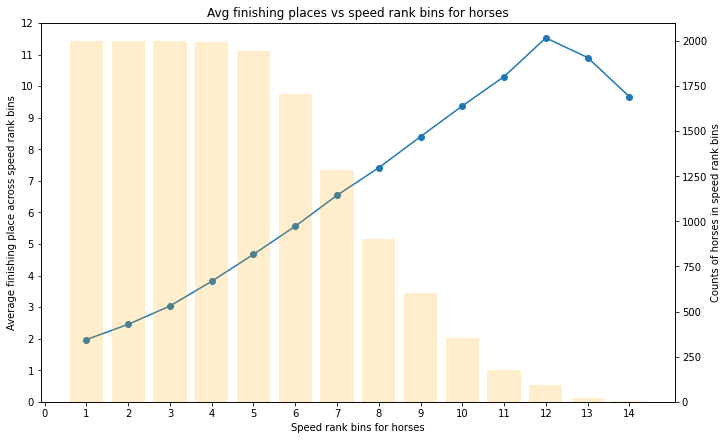

In [6]:
# Plot avg finishing_place vs speed_rank
temp = nyra_df.groupby(['speed_rank']).agg({'finishing_place' : 'mean', 'horse_id' : 'count'}).reset_index()
temp = temp.rename(columns = {'finishing_place' : 'avg_finishing_place', 'horse_id' : 'horse_counts'})

# Init the figure and axes
fig, ax1 = plt.subplots(constrained_layout=True, figsize = (10,6))
ax2 = ax1.twinx()

# Plot speed rank bins vs avg_finishing_place 
ax1.plot(temp['speed_rank'], temp['avg_finishing_place'], 'o-')
ax1.set_xticks([i for i in range(15)])
ax1.set_yticks([i for i in range(13)])
ax1.set_ylabel('Average finishing place across speed rank bins')
ax1.set_xlabel('Speed rank bins for horses')
ax1.set_title('Avg finishing places vs speed rank bins for horses')

# Plot speed rank bins vs horse counts
ax2.bar(temp['speed_rank'], temp['horse_counts'], alpha = 0.2, color = 'orange')
ax2.set_ylabel('Counts of horses in speed rank bins')

plt.show()

* We definitely see a strong relationship between the speed ranks of horses vs their finishing places
* Looks like the avg_race_speed can be a viable metric for horse performance, having a strong correlation with finishing place and might be free of other race winning factors like jockey skill (speed management, race path selection, other racing strategies)

## Horse performance over the race season

Do avg race speeds of horses change over the season? If so, is there any pattern?

### Filter to the most common types of horse races

This is to avoid avg speed variations due to track conditions


In [7]:
# Filter the race data to the most common type of track condition - Dirt and Fast (avoid )
nyra_typical_races_df = nyra_df.loc[
    (nyra_df['course_type'] == 'D') &
    (nyra_df['track_condition'] == 'FT '),
    :
]

# Some details for the most typical race dataset
print(f'Shape of the filtered data - {nyra_typical_races_df.shape}')

num_races = nyra_typical_races_df.groupby(['track_id', 'race_date', 'race_number']).ngroups
print(f'Number of \'typical\' races - {num_races}')

Shape of the filtered data - (6990, 19)
Number of 'typical' races - 978


### Get the counts of these 'typical' races for horses

In [8]:
# Get counts of typical races for horses
horse_typical_race_counts_df = nyra_typical_races_df.groupby('horse_id').agg({'race_number' : 'count'}).reset_index()
horse_typical_race_counts_df = horse_typical_race_counts_df.rename(columns = {'race_number' : 'race_counts'})
horse_typical_race_counts_df = horse_typical_race_counts_df.sort_values('race_counts', ascending = False)
horse_typical_race_counts_df.head(5)

,horse_id,race_counts
365,402,16
174,206,14
201,238,14
303,340,14
803,870,13


### Look at the speeds for high race count horses across the season

In [86]:
import matplotlib.dates as mdates
import datetime

def horse_season(races_df):
  """
  Function plots the avg speed for a horse across the 2019 season given races
  Input: df containing race data for horse of interest 
  """
  # Sort races by their dates
  races_df = races_df.sort_values('race_date', ascending = True)

  # Print speed stats
  print('Distribution of the avg race speeds across races')
  print(races_df['avg_race_speed'].describe())

  # Generate the performance plot

  # Create a avg race speed plot across the season with markers for venues / race tracks
  plt.figure(figsize = (12, 6))
  plt.plot(races_df['race_date'], races_df['avg_race_speed'], '--', color = 'black', alpha = 0.5)
  # Points to identify AQU races
  plt.scatter(races_df.loc[races_df['track_id'] == 'AQU', 'race_date'], races_df.loc[races_df['track_id'] == 'AQU', 'avg_race_speed'], s = 100, color = 'tab:brown', label = 'AQU race')
  # Points to identify BEL races
  plt.scatter(races_df.loc[races_df['track_id'] == 'BEL', 'race_date'], races_df.loc[races_df['track_id'] == 'BEL', 'avg_race_speed'], s = 100, color = 'tab:pink', label = 'BEL race')
  # Points to identify SAR races
  plt.scatter(races_df.loc[races_df['track_id'] == 'SAR', 'race_date'], races_df.loc[races_df['track_id'] == 'SAR', 'avg_race_speed'], s = 100, color = 'gold', label = 'SAR race')

  ax = plt.gca() # Get current axis (for the annotations)
  # Annotate finish positions
  for index, row in races_df.iterrows():
    ax.annotate(s = 'position : '+ str(row['finishing_place']), xy = (row['race_date'], row['avg_race_speed']), color = 'tab:cyan')

  # Show the legend
  plt.legend()
  
  # Axis labels
  plt.xlabel('Race date')
  plt.ylabel('Avg race speed (mph)')

  # Format x axis
  # Make ticks on occurrences of each month
  ax.xaxis.set_major_locator(mdates.MonthLocator())
  # Set x axis limits
  ax.set_xlim([datetime.date(2019, 1, 1), datetime.date(2020, 1, 1)])
  
  # Title
  horse_name = races_df['horse_name'].iloc[0]
  plt.title(f'Avg speed for {horse_name} for the 2019 race season')
  
  # Show the plot
  plt.show()

#### High race count examples

Distribution of the avg race speeds across races
count    16.000000
mean     41.883497
std       4.611553
min      38.654845
25%      39.474358
50%      40.778132
75%      41.692214
max      58.008012
Name: avg_race_speed, dtype: float64


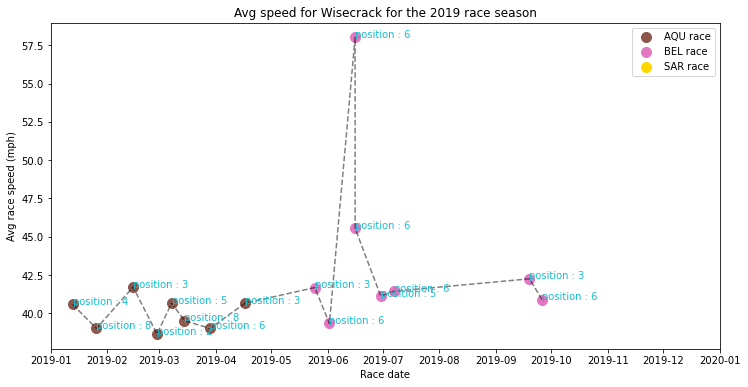

In [87]:
horse_id = 402
horse_season(nyra_typical_races_df.loc[nyra_typical_races_df['horse_id'] == horse_id, :])

* This horse seems to have a very high "outlier" speed for the 2019-06 race in BEL
* Seems to have races consistently from 2019-01 to 2019-07, then a break in atleast the 'typical' races till 2019-10, no races post 2019-10
* 3/16 top 3 finishes
* Overall, we see similar / slightly increasing speeds for the horse across the season

Distribution of the avg race speeds across races
count    14.000000
mean     41.317667
std       1.236310
min      39.350002
25%      40.548941
50%      41.439726
75%      42.320414
max      43.415430
Name: avg_race_speed, dtype: float64


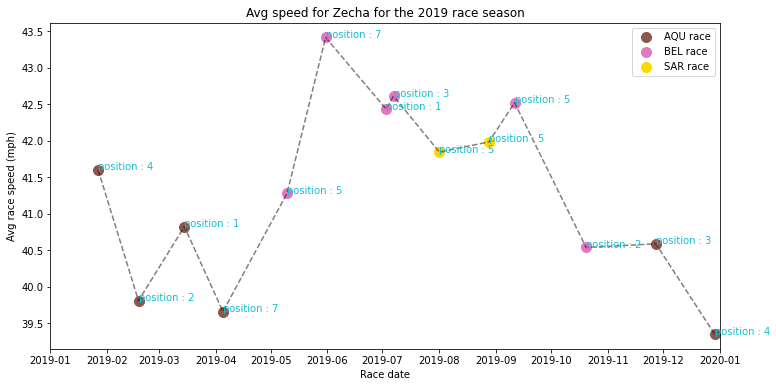

In [88]:
horse_id = 206
horse_season(nyra_typical_races_df.loc[nyra_typical_races_df['horse_id'] == horse_id, :])

* This horse seems to have a race every month in the 2019 season
* We see a horseshoe type plot for the avg race speeds, where the avg race speed increases in the 1st half of the season, peaks around 2019-06/07 and then we seem to see a decline in the avg speeds in the 2nd half of the season
* 6/14 top 3 finishes
* Looks like a pattern that we would expect, horses get used to the races, peak at the middle of the season and then race loads start to impact horse performance

Distribution of the avg race speeds across races
count    14.000000
mean     42.379959
std       3.955045
min      38.322736
25%      39.867509
50%      41.690015
75%      43.133986
max      53.556450
Name: avg_race_speed, dtype: float64


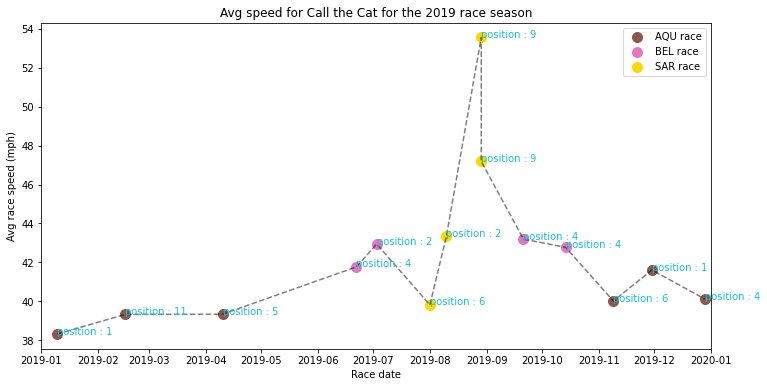

In [89]:
horse_id = 238
horse_season(nyra_typical_races_df.loc[nyra_typical_races_df['horse_id'] == horse_id, :])

* We see somewhat of a horseshoe here, horse competes in almost all months barring the break in 'typical' races from 2019-04 to 2019-06
* There is a outlier in terms of speed for the 2019-08 race at SAR, although the horse finished 9th at this pace so might be some additional factors affecting the higher avg race speeds for this race
* 4/14 top 3 finsishes

Distribution of the avg race speeds across races
count    14.000000
mean     42.250659
std       1.088551
min      40.160195
25%      41.946875
50%      42.299470
75%      42.994444
max      43.999281
Name: avg_race_speed, dtype: float64


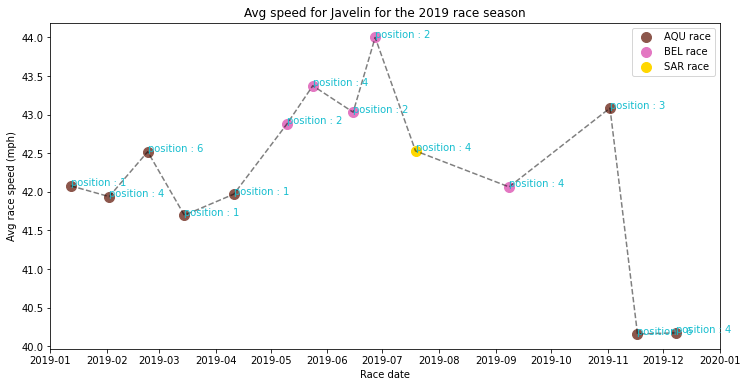

In [90]:
horse_id = 340
horse_season(nyra_typical_races_df.loc[nyra_typical_races_df['horse_id'] == horse_id, :])

* Another horseshoe example, horse peaks at 2019-07 BEL race, pretty busy season for the horse
* ~3 mph drop in average race speed from 2019-11 AQU race to 2019-11/12 AQU races
* 6/14 top 3 finishes

Distribution of the avg race speeds across races
count    13.000000
mean     41.637795
std       1.374278
min      39.959649
25%      40.584940
50%      41.817073
75%      43.211407
max      43.560463
Name: avg_race_speed, dtype: float64


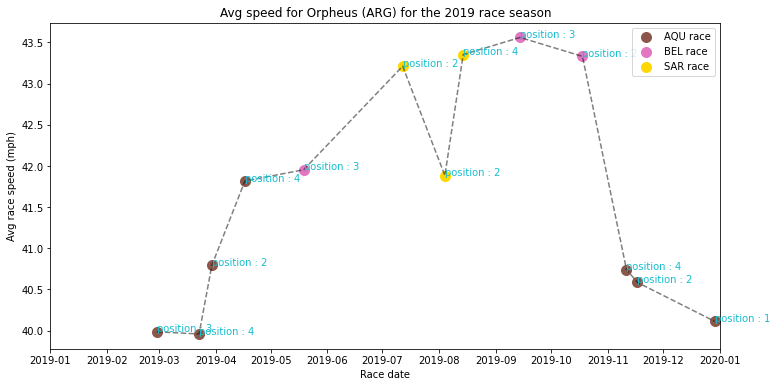

In [91]:
horse_id = 870
horse_season(nyra_typical_races_df.loc[nyra_typical_races_df['horse_id'] == horse_id, :])

* The season starts a bit late for this horse (2019-03), the horse peaks around 2019-09 i.e. a little late than the others which peak around 2019-07
* 9/13 top 3 finishes
* Looks like a top-performing horse

#### Moderate race count examples

Horses having 8-10 races per season

In [110]:
# Get horse ids having moderate (8-10) number of races in the 2019 season
print(
  'Horses having 10 races: \n',
  horse_typical_race_counts_df.loc[
      horse_typical_race_counts_df['race_counts'] == 10,
      :
  ].head(5)
)

print(
  '\nHorses having 9 races: \n',
  horse_typical_race_counts_df.loc[
      horse_typical_race_counts_df['race_counts'] == 9,
      :
  ].head(5)
)

print(
  '\nHorses having 8 races: \n',
  horse_typical_race_counts_df.loc[
      horse_typical_race_counts_df['race_counts'] == 8,
      :
  ].head(5)
)


Horses having 10 races: 
      horse_id  race_counts
410       447           10
623       686           10
291       328           10
422       459           10
988      1066           10

Horses having 9 races: 
      horse_id  race_counts
339       376            9
939      1011            9
76         90            9
423       460            9
654       717            9

Horses having 8 races: 
       horse_id  race_counts
443        480            8
11          15            8
468        505            8
802        866            8
1164      1257            8


Distribution of the avg race speeds across races
count    10.000000
mean     41.026944
std       1.099432
min      38.865095
25%      40.906530
50%      41.317065
75%      41.749486
max      42.142097
Name: avg_race_speed, dtype: float64


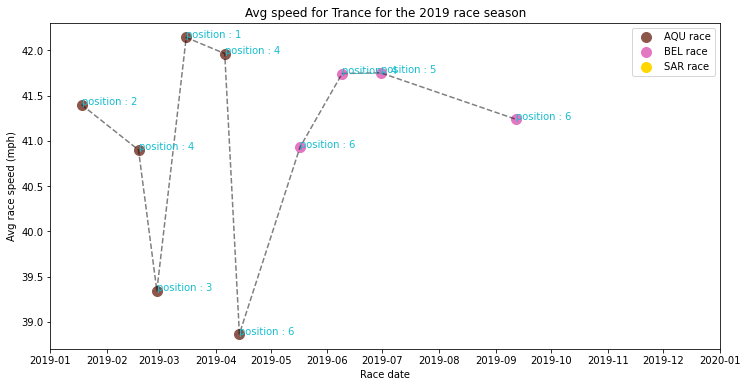

In [111]:
# 10 races example 1
horse_id = 447
horse_season(nyra_typical_races_df.loc[nyra_typical_races_df['horse_id'] == horse_id, :])

Distribution of the avg race speeds across races
count    10.000000
mean     41.542779
std       1.395582
min      38.835620
25%      40.868290
50%      41.314177
75%      42.633856
max      43.360012
Name: avg_race_speed, dtype: float64


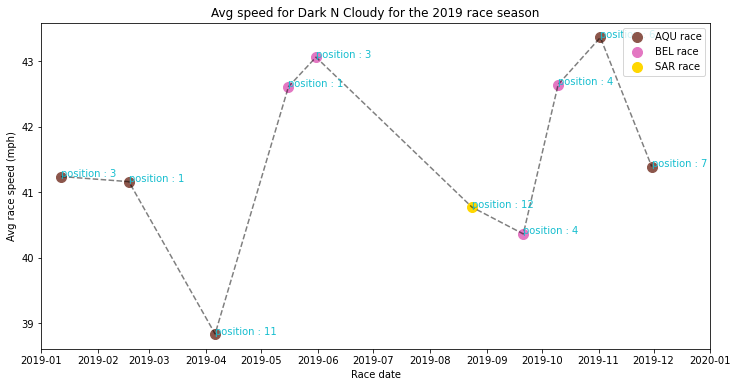

In [103]:
# 10 races example 2
# Example horse having good load management
horse_id = 328
horse_season(nyra_typical_races_df.loc[nyra_typical_races_df['horse_id'] == horse_id, :])

Distribution of the avg race speeds across races
count     9.000000
mean     40.011478
std       1.597397
min      37.259539
25%      39.324420
50%      40.352222
75%      40.813214
max      42.017354
Name: avg_race_speed, dtype: float64


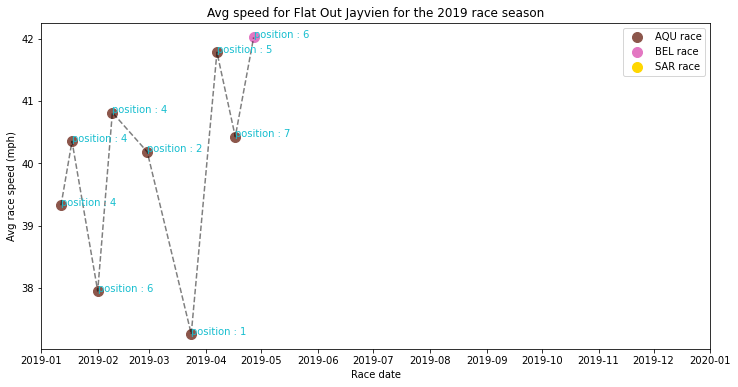

In [112]:
# 9 races example 1
horse_id = 376
horse_season(nyra_typical_races_df.loc[nyra_typical_races_df['horse_id'] == horse_id, :])

Distribution of the avg race speeds across races
count     9.000000
mean     40.430651
std       1.313497
min      37.873371
25%      40.026253
50%      40.886261
75%      41.041819
max      42.241861
Name: avg_race_speed, dtype: float64


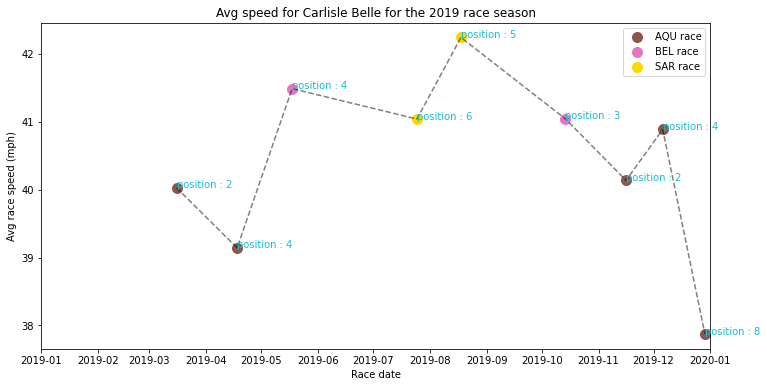

In [113]:
# 9 races example 2
horse_id = 1011
horse_season(nyra_typical_races_df.loc[nyra_typical_races_df['horse_id'] == horse_id, :])

Distribution of the avg race speeds across races
count     8.000000
mean     41.348523
std       1.079009
min      40.376726
25%      40.529059
50%      41.097519
75%      41.624936
max      43.404459
Name: avg_race_speed, dtype: float64


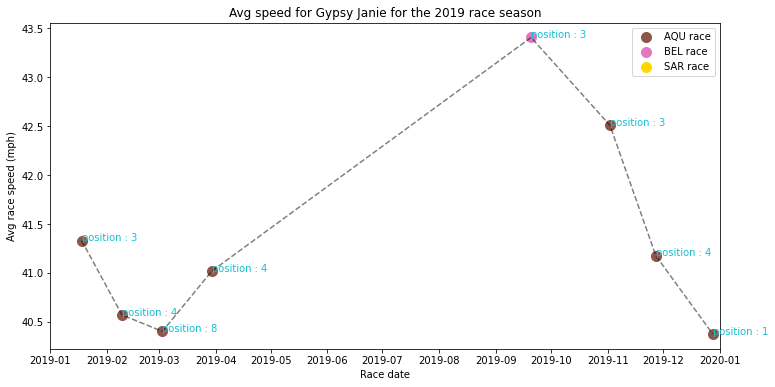

In [114]:
# 8 races example 1
horse_id = 480
horse_season(nyra_typical_races_df.loc[nyra_typical_races_df['horse_id'] == horse_id, :])

Distribution of the avg race speeds across races
count     8.000000
mean     41.099926
std       1.011275
min      39.402058
25%      40.953688
50%      41.561534
75%      41.647722
max      41.952613
Name: avg_race_speed, dtype: float64


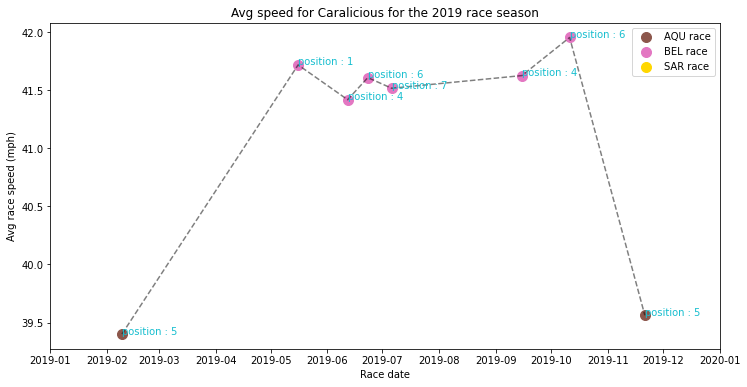

In [115]:
# 8 races example 2
horse_id = 15
horse_season(nyra_typical_races_df.loc[nyra_typical_races_df['horse_id'] == horse_id, :])

#### Comparatively low number of races
Horses having 4-6 races in the season

In [116]:
# Get horse ids having low (4-6) number of races in the 2019 season
print(
  'Horses having 6 races: \n',
  horse_typical_race_counts_df.loc[
      horse_typical_race_counts_df['race_counts'] == 6,
      :
  ].head(5)
)

print(
  '\nHorses having 5 races: \n',
  horse_typical_race_counts_df.loc[
      horse_typical_race_counts_df['race_counts'] == 5,
      :
  ].head(5)
)

print(
  '\nHorses having 4 races: \n',
  horse_typical_race_counts_df.loc[
      horse_typical_race_counts_df['race_counts'] == 4,
      :
  ].head(5)
)


Horses having 6 races: 
       horse_id  race_counts
737        800            6
692        755            6
397        434            6
271        308            6
1188      1289            6

Horses having 5 races: 
       horse_id  race_counts
567        626            5
92         106            5
963       1037            5
967       1041            5
1860      2551            5

Horses having 4 races: 
      horse_id  race_counts
746       809            4
590       653            4
642       705            4
561       620            4
646       709            4


Distribution of the avg race speeds across races
count     6.000000
mean     41.607583
std       0.644416
min      40.680210
25%      41.241111
50%      41.621620
75%      42.019403
max      42.455775
Name: avg_race_speed, dtype: float64


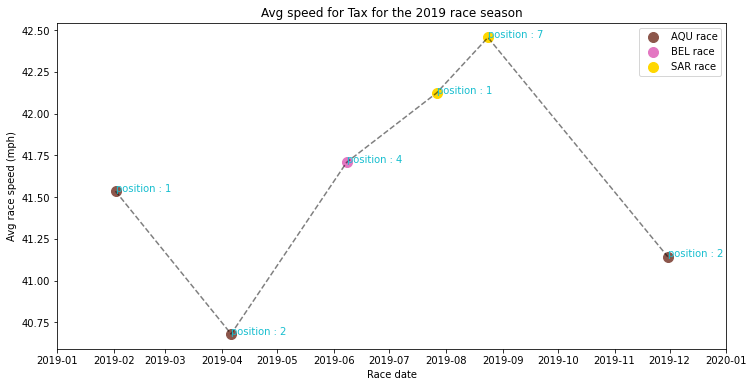

In [117]:
# 6 races example 1
horse_id = 800
horse_season(nyra_typical_races_df.loc[nyra_typical_races_df['horse_id'] == horse_id, :])

Distribution of the avg race speeds across races
count     6.000000
mean     43.130301
std       2.164767
min      39.949809
25%      42.098985
50%      43.388017
75%      43.888308
max      46.331584
Name: avg_race_speed, dtype: float64


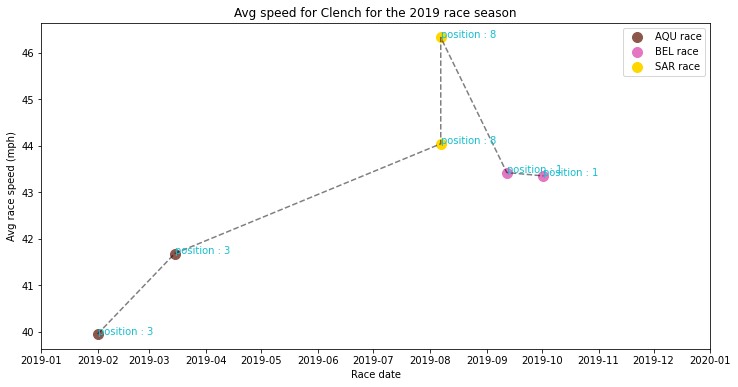

In [118]:
# 6 races example 2
horse_id = 755
horse_season(nyra_typical_races_df.loc[nyra_typical_races_df['horse_id'] == horse_id, :])

Distribution of the avg race speeds across races
count     5.000000
mean     42.222556
std       1.242555
min      40.216238
25%      41.837007
50%      42.853733
75%      42.939477
max      43.266324
Name: avg_race_speed, dtype: float64


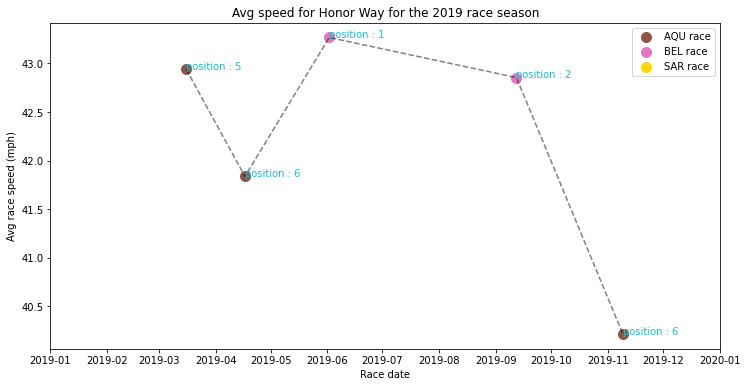

In [119]:
# 5 races example 1
horse_id = 626
horse_season(nyra_typical_races_df.loc[nyra_typical_races_df['horse_id'] == horse_id, :])

Distribution of the avg race speeds across races
count     5.000000
mean     40.360231
std       0.953494
min      38.705997
25%      40.506990
50%      40.639767
75%      40.821694
max      41.126707
Name: avg_race_speed, dtype: float64


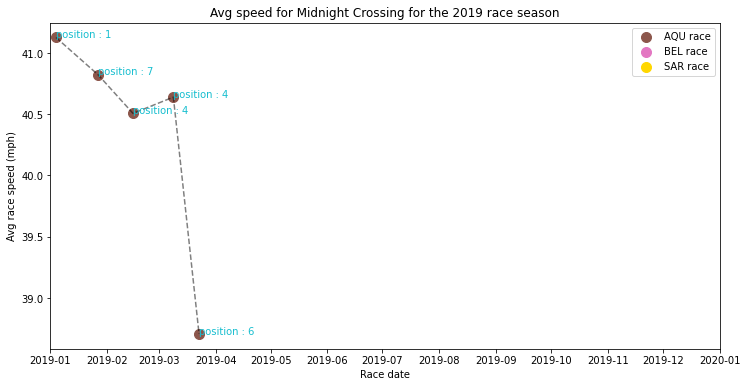

In [120]:
# 5 races example 2
horse_id = 106
horse_season(nyra_typical_races_df.loc[nyra_typical_races_df['horse_id'] == horse_id, :])

Horse injury? drop in race speed and a short season

Distribution of the avg race speeds across races
count     4.000000
mean     40.960569
std       0.231375
min      40.788378
25%      40.833653
50%      40.876844
75%      41.003760
max      41.300208
Name: avg_race_speed, dtype: float64


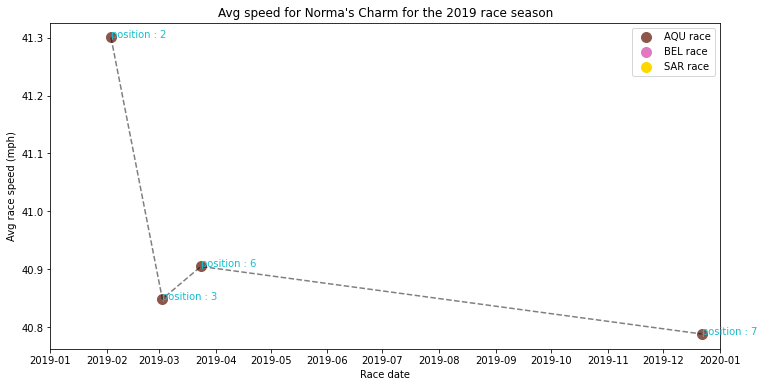

In [121]:
# 4 races example 1
horse_id = 809
horse_season(nyra_typical_races_df.loc[nyra_typical_races_df['horse_id'] == horse_id, :])

Distribution of the avg race speeds across races
count     4.000000
mean     40.851801
std       1.142558
min      40.228327
25%      40.237564
50%      40.308080
75%      40.922317
max      42.562718
Name: avg_race_speed, dtype: float64


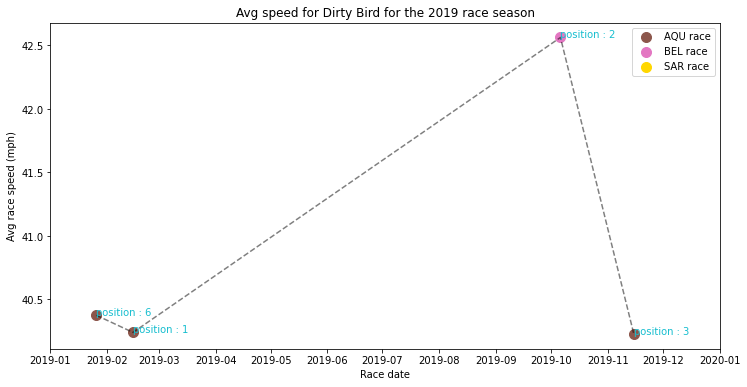

In [122]:
# 4 races example 2
horse_id = 653
horse_season(nyra_typical_races_df.loc[nyra_typical_races_df['horse_id'] == horse_id, :])

## Top 3 finish percentage vs number of races in a season
View might be able to point towards lesser races i.e. lesser load leading to horses having better race performances

# End of notebook